In [55]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import collections
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\farsharb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farsharb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\farsharb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\farsharb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [56]:
df = pd.read_csv("C:/Users/farsharb/Desktop/NLP/vaccination_tweets.csv")
df.head(2)

id    user_name              user_location  \
0  1340539111971516416   Rachel Roh  La Crescenta-Montrose, CA   
1  1338158543359250433  Albert Fong          San Francisco, CA   

                                    user_description         user_created  \
0  Aggregator of Asian American news; scanning di...  2009-04-08 17:52:46   
1  Marketing dude, tech geek, heavy metal & '80s ...  2009-09-21 15:27:30   

   user_followers  user_friends  user_favourites  user_verified  \
0             405          1692             3247          False   
1             834           666              178          False   

                  date                                               text  \
0  2020-12-20 06:06:44  Same folks said daikon paste could treat a cyt...   
1  2020-12-13 16:27:13  While the world has been on the wrong side of ...   

             hashtags               source  retweets  favorites  is_retweet  
0  ['PfizerBioNTech']  Twitter for Android         0          0       False  
1                 NaN      Twitter Web App         1          1       False

In [57]:
df.shape

(8082, 16)

In [260]:
text_df["text"][4]

'explain need vaccine whereareallthesickpeople pfizerbiontech'

In [258]:
df["text"][4]

'Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq'

In [58]:
df = df.drop_duplicates('text')
print(df.shape)

(8075, 16)


In [59]:
# Extracting only Text attributs for analysis
text_df = df.drop(['id', 'user_name', 'user_description', 'user_location',
       'user_followers', 'user_friends', 'user_favourites', 'user_verified',
        'source','is_retweet'],axis=1)
text_df.head()

user_created                 date  \
0  2009-04-08 17:52:46  2020-12-20 06:06:44   
1  2009-09-21 15:27:30  2020-12-13 16:27:13   
2  2020-06-25 23:30:28  2020-12-12 20:33:45   
3  2008-09-10 11:28:53  2020-12-12 20:23:59   
4  2020-04-23 17:58:42  2020-12-12 20:17:19   

                                                text  \
0  Same folks said daikon paste could treat a cyt...   
1  While the world has been on the wrong side of ...   
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  Facts are immutable, Senator, even when you're...   
4  Explain to me again why we need a vaccine @Bor...   

                                            hashtags  retweets  favorites  
0                                 ['PfizerBioNTech']         0          0  
1                                                NaN         1          1  
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...         0          0  
3                                                NaN       446       2129  
4     ['whereareallthesickpeople', 'PfizerBioNTech']         0          0

In [60]:
# Convert the 'date' column to datetime format
text_df['date'] = pd.to_datetime(text_df['date'])
text_df['date'] = text_df['date'].dt.strftime('%Y-%m-%d')

text_df['user_created'] = pd.to_datetime(text_df['user_created'])
text_df['user_created'] = text_df['user_created'].dt.strftime('%Y-%m-%d')

In [61]:
text_df['text'] = text_df['text'].astype(str)

In [62]:
def preprocess_tweets(text):
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#', ' ', text)
    text = re.sub(r'RT[\s]+', ' ', text)
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    text = text.lower()
    return text

text_df['text'] = text_df['text'].apply(preprocess_tweets)
text_df.head(2)

user_created        date                                               text  \
0   2009-04-08  2020-12-20  same folks said daikon paste could treat a cyt...   
1   2009-09-21  2020-12-13  while the world has been on the wrong side of ...   

             hashtags  retweets  favorites  
0  ['PfizerBioNTech']         0          0  
1                 NaN         1          1

In [63]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

def data_processing(text):
    text = text.lower()     # Converting to text to lowercase
    text = re.sub(r'https\S+|www\S+https\S+','',text,flags=re.MULTILINE)   # Removing URLs
    text = re.sub(r'\@w+|\#','',text)         # Removing hashtags
    text = re.sub(r'[^\w\s]','',text)         # Removing punctuation
    text_tokens = word_tokenize(text)         # Getting tokens
    filtered_text = ' '.join([w for w in text_tokens if not w in stop_words])
    doc = nlp(filtered_text)
    return " ".join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc])

In [64]:
text_df['text'] = text_df['text'].apply(data_processing)

In [65]:
def handle_emoji(tex):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',tex)

text_df['text'] = text_df['text'].apply(handle_emoji)

In [69]:
text_df['text'] = text_df['text'].str.replace(r'covid\s*19?', 'covid', flags=re.IGNORECASE)

# Replace 'covidvaccine', 'covidvaccin', 'covid19vaccine', 'covid19vaccin', '19vaccine', '19vaccin', 'covid vaccine', 'covid vaccin', 'covid19 vaccine', 'covid 19 vaccine', 'covid 19 vaccin', 'covid19 vaccine', 'covid19vaccin', 'covid19vaccine' with 'vaccine'
text_df['text'] = text_df['text'].str.replace(r'covid\s*vaccin?e?\s*19?', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace(r'covidvaccin?e?\s*19?', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace(r'covidvaccine?\s*19?', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace(r'covid19vaccine*19?', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace(r'covid19 vaccine*19?', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace('covid19 vaccine', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace('covid vaccine', 'vaccine', flags=re.IGNORECASE)
text_df['text'] = text_df['text'].str.replace('covid 19 vaccine', 'vaccine', flags=re.IGNORECASE)

C:\Users\farsharb\AppData\Local\Temp/ipykernel_17572/160770870.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  text_df['text'] = text_df['text'].str.replace(r'covid\s*19?', 'covid', flags=re.IGNORECASE)
C:\Users\farsharb\AppData\Local\Temp/ipykernel_17572/160770870.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  text_df['text'] = text_df['text'].str.replace(r'covid\s*vaccin?e?\s*19?', 'vaccine', flags=re.IGNORECASE)
C:\Users\farsharb\AppData\Local\Temp/ipykernel_17572/160770870.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  text_df['text'] = text_df['text'].str.replace(r'covidvaccin?e?\s*19?', 'vaccine', flags=re.IGNORECASE)
C:\Users\farsharb\AppData\Local\Temp/ipykernel_17572/160770870.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  text_df['text'] = text_df['text'].str.r

In [70]:
text_df['text'] = text_df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')

C:\Users\farsharb\AppData\Local\Temp/ipykernel_17572/2441733642.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  text_df['text'] = text_df['text'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


In [71]:
#visualizing Processed text
print(text_df["text"].iloc[0],"\n")
print(text_df["text"].iloc[1],"\n")
print(text_df["text"].iloc[2],"\n")
print(text_df["text"].iloc[3],"\n")
print(text_df["text"].iloc[4],"\n")
print(text_df["text"].iloc[5],"\n")

folk say daikon paste could treat cytokine storm pfizerbiontech 

world wrong side history year hopefully big vaccination effort we ve ev 

coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_19 russian vaccine create last 24 year 

fact immutable senator even you re ethically sturdy enough acknowledge 1 bear 

explain need vaccine whereareallthesickpeople pfizerbiontech 

anyone useful adviceguidance whether vaccine safe whilst breastfeed 



In [72]:
sid = SentimentIntensityAnalyzer()

def sentence_sentiment(text):
    """
    Analyze the sentiment of each sentence in a string.

    Parameters:
    text (str): A string containing one or more sentences.

    Returns:
    float: The average compound sentiment score for all sentences in the string.
    """
    # Split the text into sentences
    sentences = text.split('.')
    
    # Remove any empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    if not sentences:
        return 0  # or another default value, such as np.nan

    # Calculate the sentiment scores for each sentence
    scores = [sid.polarity_scores(sentence)['compound'] for sentence in sentences]

    # Calculate the average compound sentiment score
    avg_score = sum(scores) / len(scores)

    return avg_score

In [73]:
text_df["polarity_sent_vader"] = text_df["text"].apply(sentence_sentiment)
text_df.head(2)

user_created        date                                               text  \
0   2009-04-08  2020-12-20  folk say daikon paste could treat cytokine sto...   
1   2009-09-21  2020-12-13  world wrong side history year hopefully big va...   

             hashtags  retweets  favorites  polarity_sent_vader  
0  ['PfizerBioNTech']         0          0               0.4019  
1                 NaN         1          1              -0.1027

In [74]:
pol1=text_df.groupby("date")["polarity_sent_vader"].mean().reset_index()
pol1["date"]=pd.to_datetime(pol1["date"])
pol1=pol1.sort_values(by='date')

# Textblob

In [75]:
from textblob import TextBlob
import pandas as pd

def sentence_sentiment(text):
    """
    Analyze the sentiment of each sentence in a string.

    Parameters:
    text (str): A string containing one or more sentences.

    Returns:
    float: The average sentiment score for all sentences in the string.
    """
    # Split the text into sentences
    sentences = text.split('.')
    
    # Remove any empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    if not sentences:
        return 0  # or another default value, such as np.nan

    # Calculate the sentiment scores for each sentence
    scores = [TextBlob(sentence).sentiment.polarity for sentence in sentences]

    # Calculate the average sentiment score
    avg_score = sum(scores) / len(scores)

    return avg_score


# Apply the function to the text column
text_df["polarity_sent_TextBlob"] = text_df["text"].apply(sentence_sentiment)

text_df.head(2)

user_created        date                                               text  \
0   2009-04-08  2020-12-20  folk say daikon paste could treat cytokine sto...   
1   2009-09-21  2020-12-13  world wrong side history year hopefully big va...   

             hashtags  retweets  favorites  polarity_sent_vader  \
0  ['PfizerBioNTech']         0          0               0.4019   
1                 NaN         1          1              -0.1027   

   polarity_sent_TextBlob  
0                    0.00  
1                   -0.25

In [76]:
pol=text_df.groupby("date")["polarity_sent_TextBlob"].mean().reset_index()
pol["date"]=pd.to_datetime(pol["date"])
pol=pol.sort_values(by='date')

<AxesSubplot: title={'center': 'Average Polarity during time'}, xlabel='date', ylabel='polarity_sent_vader'>

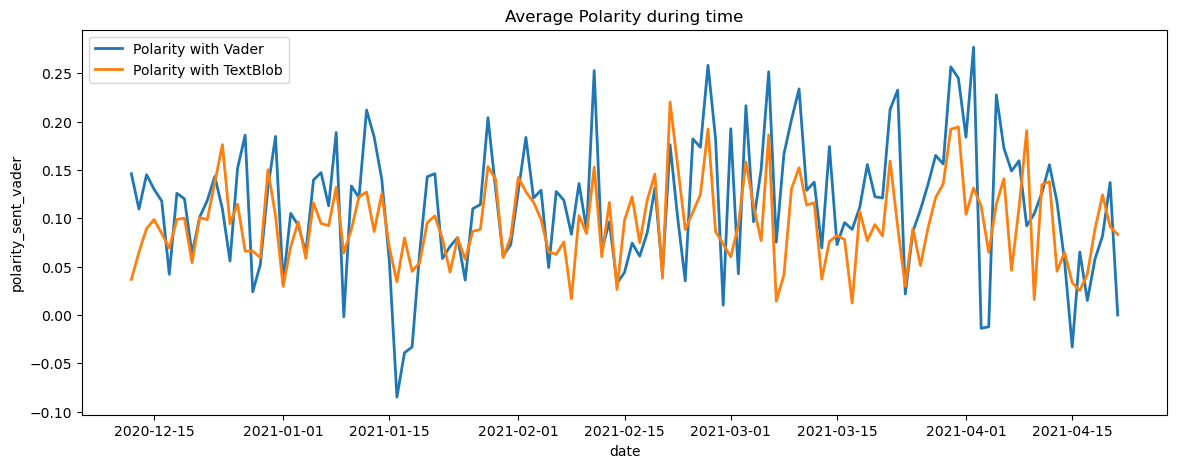

In [77]:
plt.figure(figsize=(14,5))
plt.title("Average Polarity during time")
sns.lineplot(x='date', y='polarity_sent_vader', linewidth=2, data=pol1, label='Polarity with Vader')
sns.lineplot(x='date', y='polarity_sent_TextBlob', linewidth=2, data=pol, label='Polarity with TextBlob')

# Avg, MIN, MAX, STD of TextBlob and Vader polarity

In [78]:
print(pol["polarity_sent_TextBlob"].mean())
print(pol["polarity_sent_TextBlob"].min())
print(pol["polarity_sent_TextBlob"].max())
print(pol["polarity_sent_TextBlob"].std())
print('\n')

print(pol1["polarity_sent_vader"].mean())
print(pol1["polarity_sent_vader"].min())
print(pol1["polarity_sent_vader"].max())
print(pol1["polarity_sent_vader"].std())

0.09441589207437326
0.012321658837616285
0.22035137085137085
0.0419804706908176


0.1140354108802457
-0.0851325581395349
0.2770423076923077
0.06842238162143574


# 

In [79]:
#  Adding Sentiment to the data frame
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [80]:
text_df['sentiment_vader'] = text_df['polarity_sent_vader'].apply(sentiment)
text_df.head(2)

user_created        date                                               text  \
0   2009-04-08  2020-12-20  folk say daikon paste could treat cytokine sto...   
1   2009-09-21  2020-12-13  world wrong side history year hopefully big va...   

             hashtags  retweets  favorites  polarity_sent_vader  \
0  ['PfizerBioNTech']         0          0               0.4019   
1                 NaN         1          1              -0.1027   

   polarity_sent_TextBlob sentiment_vader  
0                    0.00        Positive  
1                   -0.25        Negative

In [81]:
text_df['sentiment_TextBlob'] = text_df['polarity_sent_TextBlob'].apply(sentiment)
text_df.head(2)

user_created        date                                               text  \
0   2009-04-08  2020-12-20  folk say daikon paste could treat cytokine sto...   
1   2009-09-21  2020-12-13  world wrong side history year hopefully big va...   

             hashtags  retweets  favorites  polarity_sent_vader  \
0  ['PfizerBioNTech']         0          0               0.4019   
1                 NaN         1          1              -0.1027   

   polarity_sent_TextBlob sentiment_vader sentiment_TextBlob  
0                    0.00        Positive            Neutral  
1                   -0.25        Negative           Negative

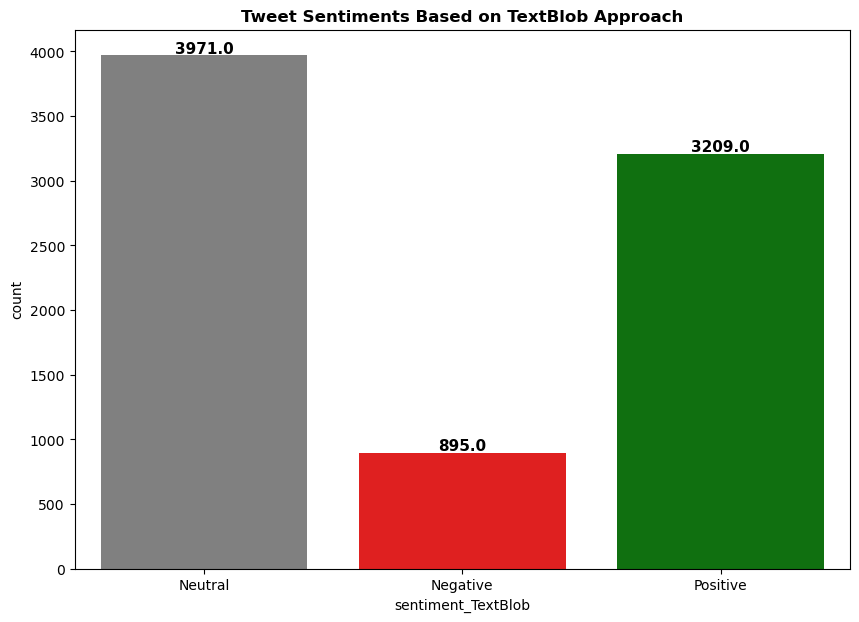

In [82]:
# Define the colors for each category
colors = {"Negative": "red", "Neutral": "gray", "Positive": "green"}

fig = plt.figure(figsize=(10,7))
ax = sns.countplot(x="sentiment_TextBlob", data=text_df, palette=colors)
ax.set_title("Tweet Sentiments Based on TextBlob Approach", fontweight='bold')

# Add the count of each category on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),fontweight='bold',
                textcoords='offset points')

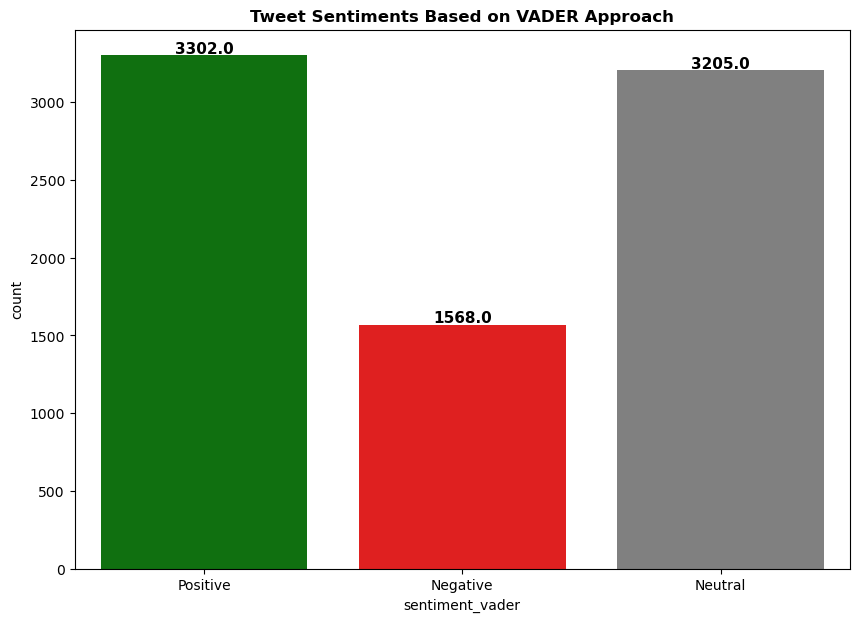

In [83]:
# Define the colors for each category
colors = {"Negative": "red", "Neutral": "gray", "Positive": "green"}

fig = plt.figure(figsize=(10,7))
ax = sns.countplot(x="sentiment_vader", data=text_df, palette=colors)
ax.set_title("Tweet Sentiments Based on VADER Approach", fontweight='bold')

# Add the count of each category on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),fontweight='bold',
                textcoords='offset points')

Text(0.5, 1.0, 'Distribution of sentiments Based on TextBlob Approach')

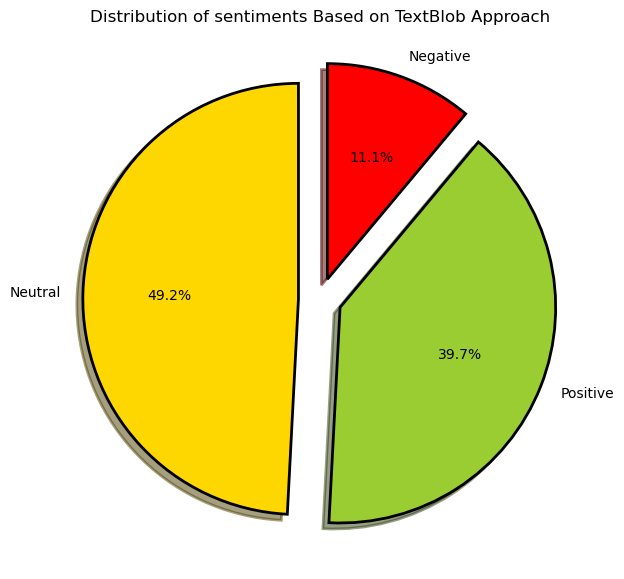

In [84]:
fig = plt.figure(figsize=(7,7))
colors = ("gold","yellowgreen", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment_TextBlob'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments Based on TextBlob Approach')

Text(0.5, 1.0, 'Distribution of sentiments Based on VADER Approach')

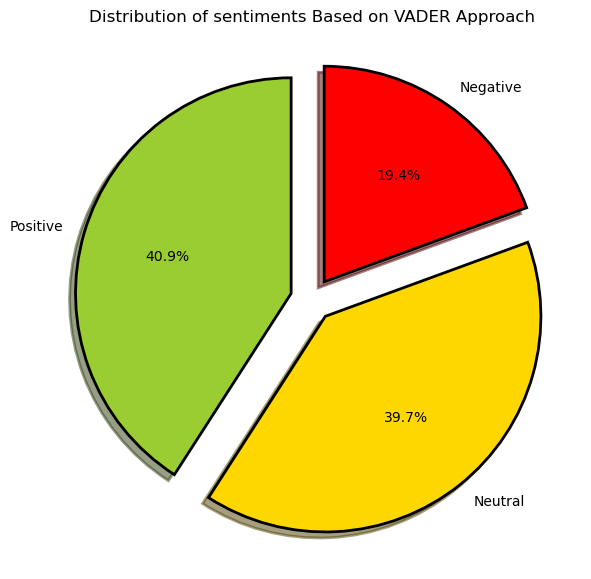

In [85]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment_vader'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments Based on VADER Approach')

# Text cloud (VADER)

In [86]:
#Visulaizing Top 5 positive Sentiments
pos_tweets = text_df[text_df.sentiment_vader == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity_sent_vader'], ascending= False)
pos_tweets.head(2)

user_created        date  \
7906   2012-01-16  2021-04-18   
3215   2015-10-15  2021-01-11   

                                                   text hashtags  retweets  \
7906  great hope every eu citizen able get safe effe...      NaN         0   
3215  glad join vaccine positive cohort impress proc...      NaN         0   

      favorites  polarity_sent_vader  polarity_sent_TextBlob sentiment_vader  \
7906          0               0.9382                0.600000        Positive   
3215          6               0.9313                0.367424        Positive   

     sentiment_TextBlob  
7906           Positive  
3215           Positive

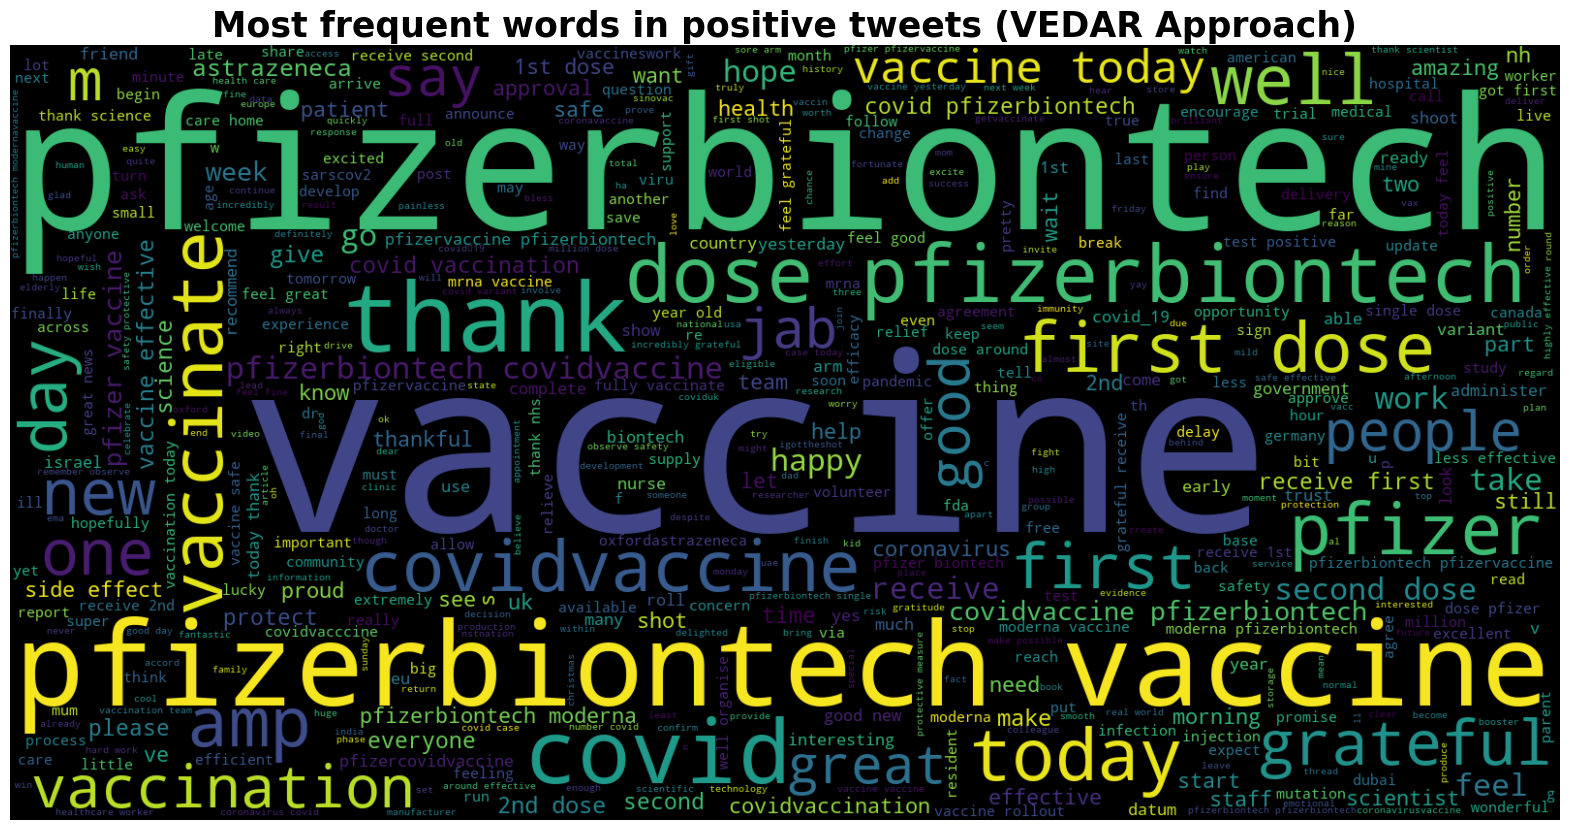

In [87]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets (VEDAR Approach)', fontsize=25, weight='bold')
plt.show()

In [88]:
#Visulaizing Top 5 positive Sentiments
neg_tweets = text_df[text_df.sentiment_vader == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity_sent_vader'], ascending= False)
neg_tweets.head(2)

user_created        date  \
2387   2009-07-15  2021-01-05   
7415   2015-02-12  2021-04-01   

                                                   text hashtags  retweets  \
2387  do not matter many vaccine get push 2nd dose o...      NaN         4   
7415  week ago take second dose could not happy fina...      NaN         0   

      favorites  polarity_sent_vader  polarity_sent_TextBlob sentiment_vader  \
2387          6              -0.0191                0.166667        Negative   
7415          2              -0.0253                0.025000        Negative   

     sentiment_TextBlob  
2387           Positive  
7415           Positive

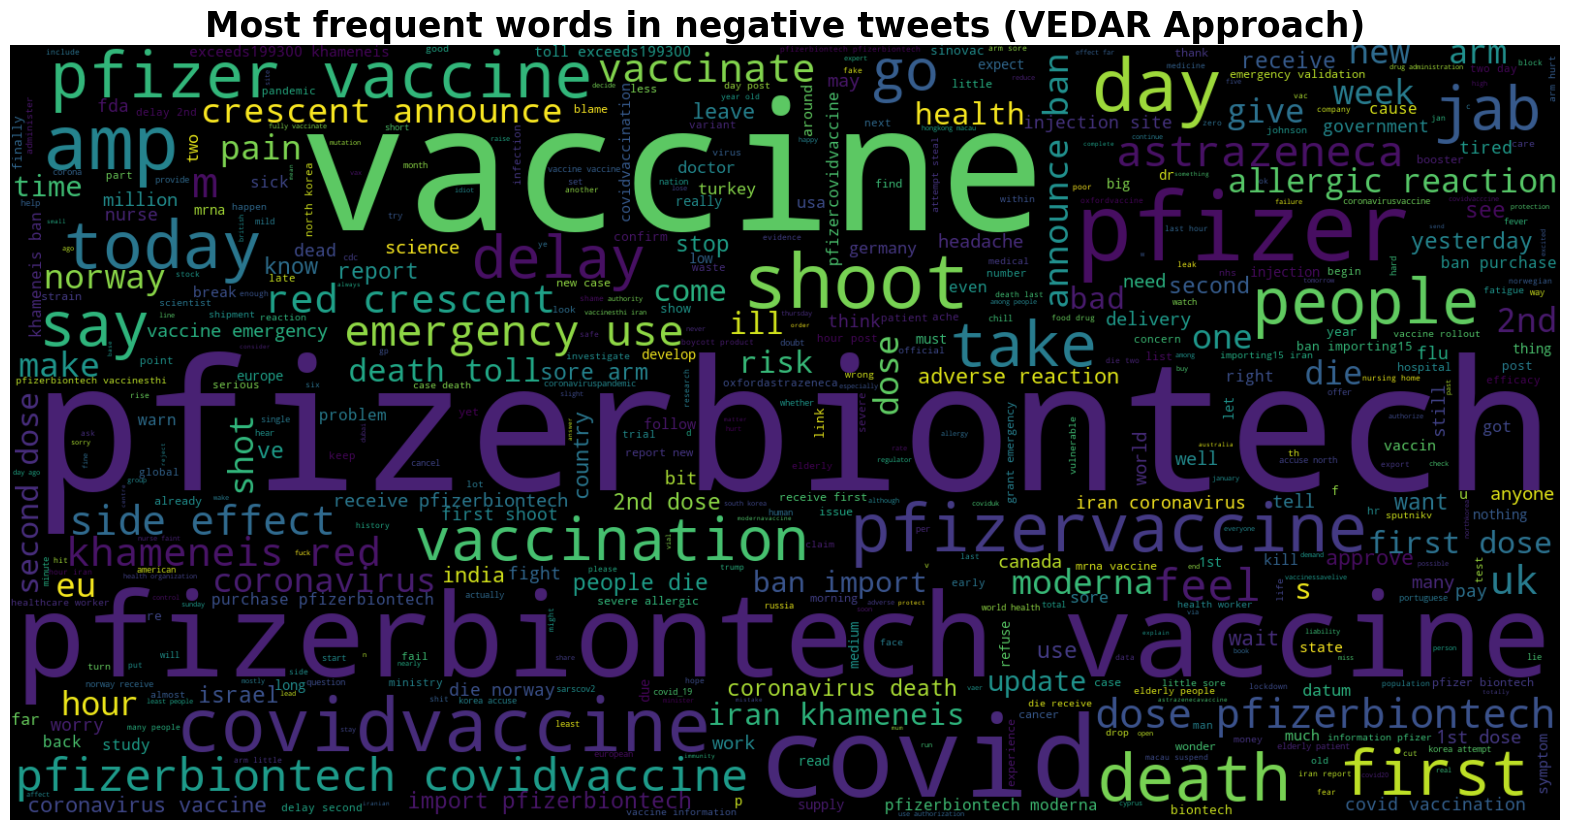

In [89]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets (VEDAR Approach)', fontsize=25, weight='bold')
plt.show()

In [90]:
#Visulaizing Top 5 positive Sentiments
neu_tweets = text_df[text_df.sentiment_vader == 'Neutral']
neu_tweets = neu_tweets.sort_values(['polarity_sent_vader'], ascending= False)
neu_tweets.head(2)

user_created        date  \
3      2008-09-10  2020-12-12   
5457   2016-11-22  2021-02-10   

                                                   text hashtags  retweets  \
3     fact immutable senator even you re ethically s...      NaN       446   
5457  people preexist medical condition likely requi...      NaN         0   

      favorites  polarity_sent_vader  polarity_sent_TextBlob sentiment_vader  \
3          2129                  0.0                     0.1         Neutral   
5457          0                  0.0                     0.0         Neutral   

     sentiment_TextBlob  
3              Positive  
5457            Neutral

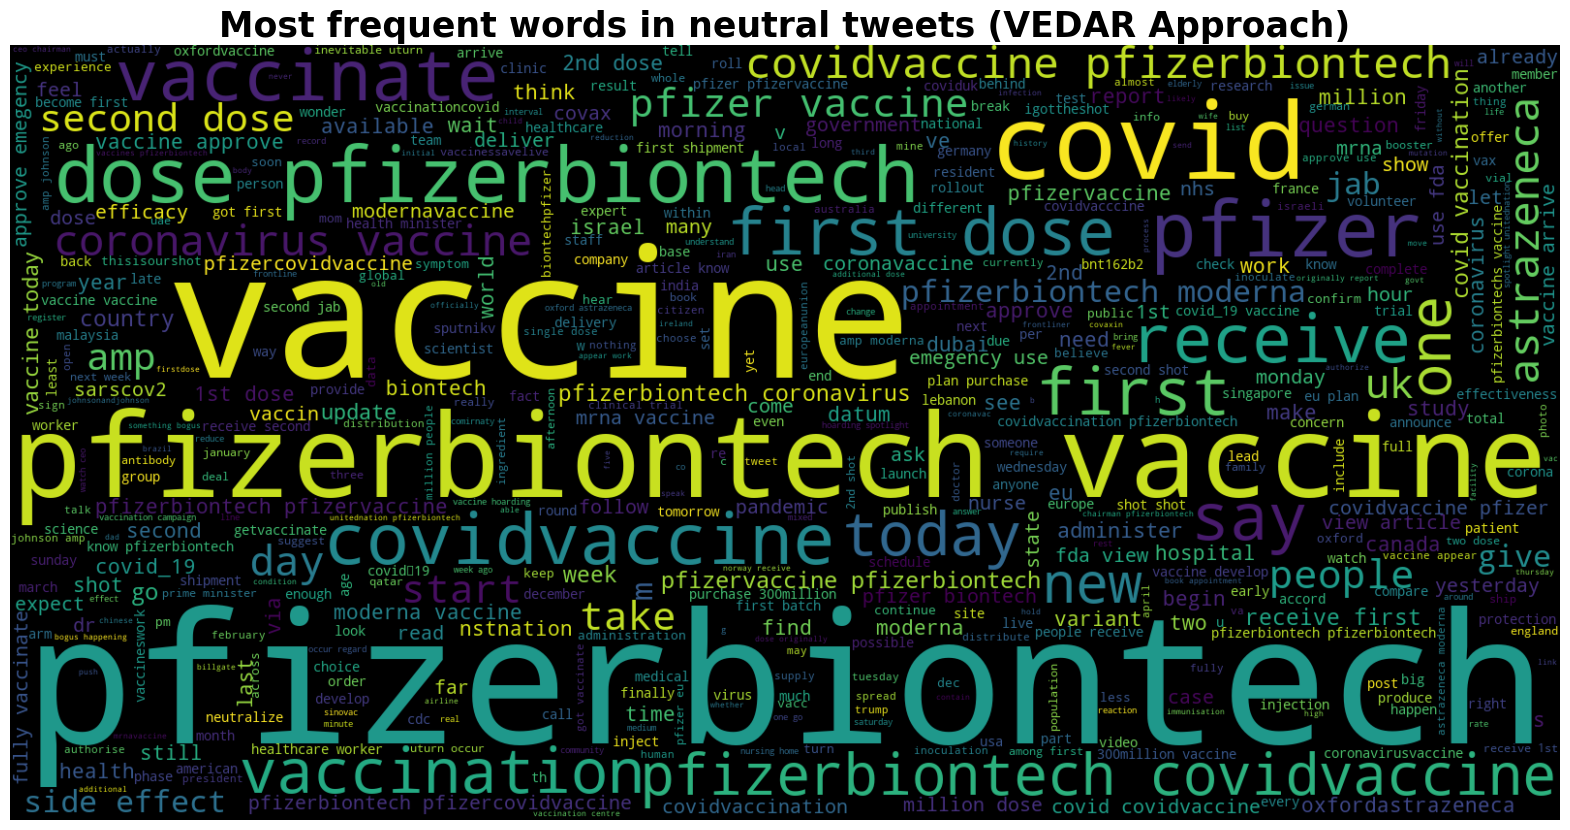

In [91]:
text = ' '.join([word for word in neu_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets (VEDAR Approach)', fontsize=25, weight='bold')
plt.show()

In [92]:
text_df['user_created']=pd.to_datetime(text_df['user_created'])
text_df['user_created_year'] = text_df['user_created'].dt.strftime('%Y')

In [261]:
user_created=text_df.groupby(by=["user_created_year","sentiment_vader"])['polarity_sent_vader'].count().reset_index()

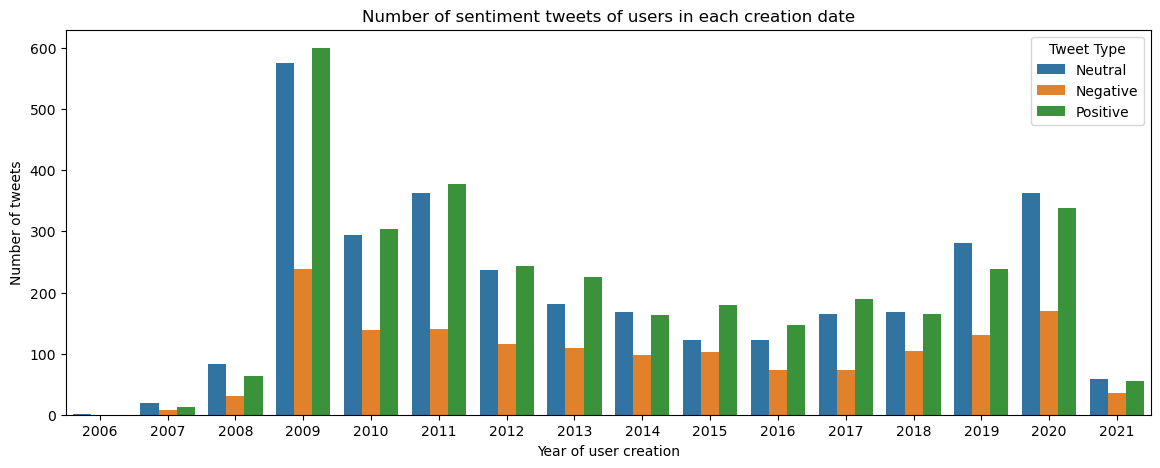

In [262]:
plt.figure(figsize=(14,5))
sns.barplot(
    x='user_created_year', 
    y='polarity_sent_vader', 
    hue='sentiment_vader', 
    data=user_created
)

plt.xlabel('Year of user creation')
plt.ylabel('Number of tweets')
plt.legend(title='Tweet Type')
plt.title("Number of sentiment tweets of users in each creation date")
plt.show()

In [95]:
# Data Cleaning
def clean_text(text):
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    return text
pos_tweets['clean_text'] = pos_tweets['text'].apply(clean_text)
totalTarget_pos = ' '.join(pos_tweets['clean_text'])
totalTarget_pos = totalTarget_pos.split()
freq_dist = nltk.FreqDist(totalTarget_pos)
freq_dist = pd.DataFrame({'word':list(freq_dist.keys()),'count':list(freq_dist.values())})

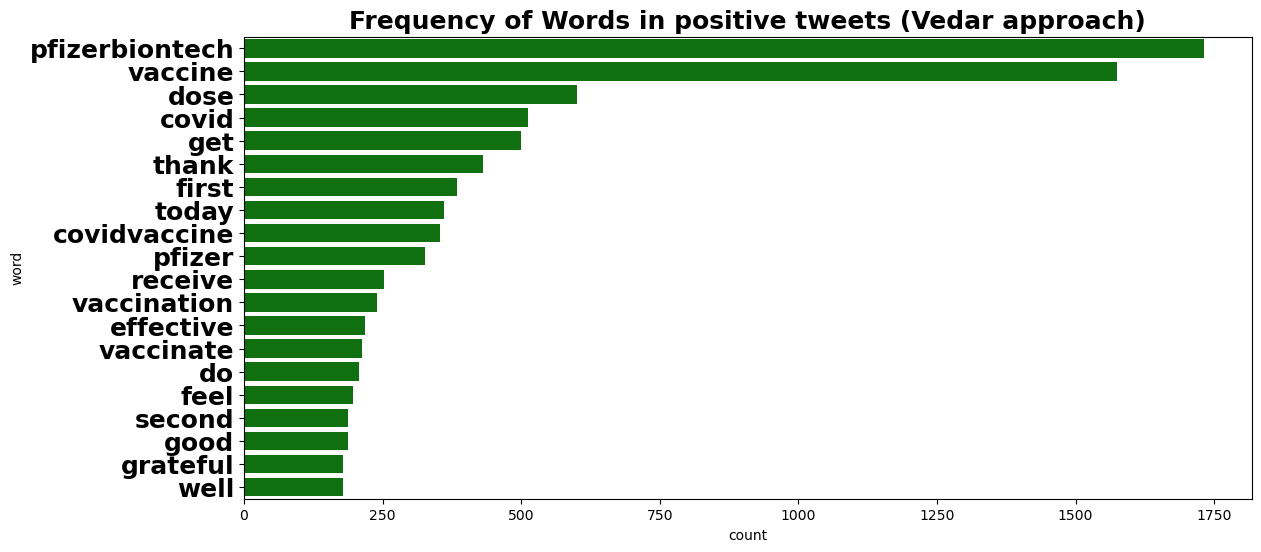

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using Seaborn
plt.figure(figsize=(13, 6))
sns.barplot(x='count', y='word', data=freq_dist.nlargest(20, 'count').sort_values('count', ascending=False), color='green')
plt.title('Frequency of Words in positive tweets (Vedar approach)' ,fontsize=18, weight='bold')

# Adjust the font size of the y-axis tick labels
plt.yticks(fontsize=18, weight='bold')

plt.show()


In [97]:
neg_tweets['clean_text'] = neg_tweets['text'].apply(clean_text)
totalTarget_neg = ' '.join(neg_tweets['clean_text'])
totalTarget_neg = totalTarget_neg.split()
freq_dist = nltk.FreqDist(totalTarget_neg)
freq_dist = pd.DataFrame({'word':list(freq_dist.keys()),'count':list(freq_dist.values())})

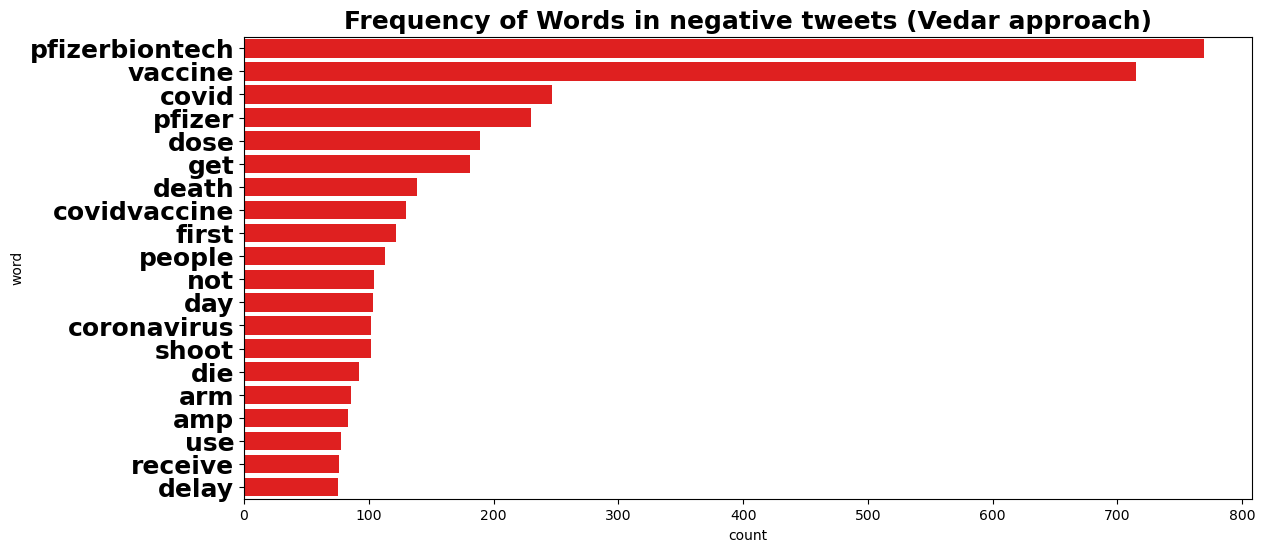

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using Seaborn
plt.figure(figsize=(13, 6))
sns.barplot(x='count', y='word', data=freq_dist.nlargest(20, 'count').sort_values('count', ascending=False), color='red')
plt.title('Frequency of Words in negative tweets (Vedar approach)' ,fontsize=18, weight='bold')

# Adjust the font size of the y-axis tick labels
plt.yticks(fontsize=18, weight='bold')

plt.show()


In [99]:
neu_tweets['clean_text'] = neu_tweets['text'].apply(clean_text)
totalTarget_neu = ' '.join(neu_tweets['clean_text'])
totalTarget_neu = totalTarget_neu.split()
freq_dist = nltk.FreqDist(totalTarget_neu)
freq_dist = pd.DataFrame({'word':list(freq_dist.keys()),'count':list(freq_dist.values())})

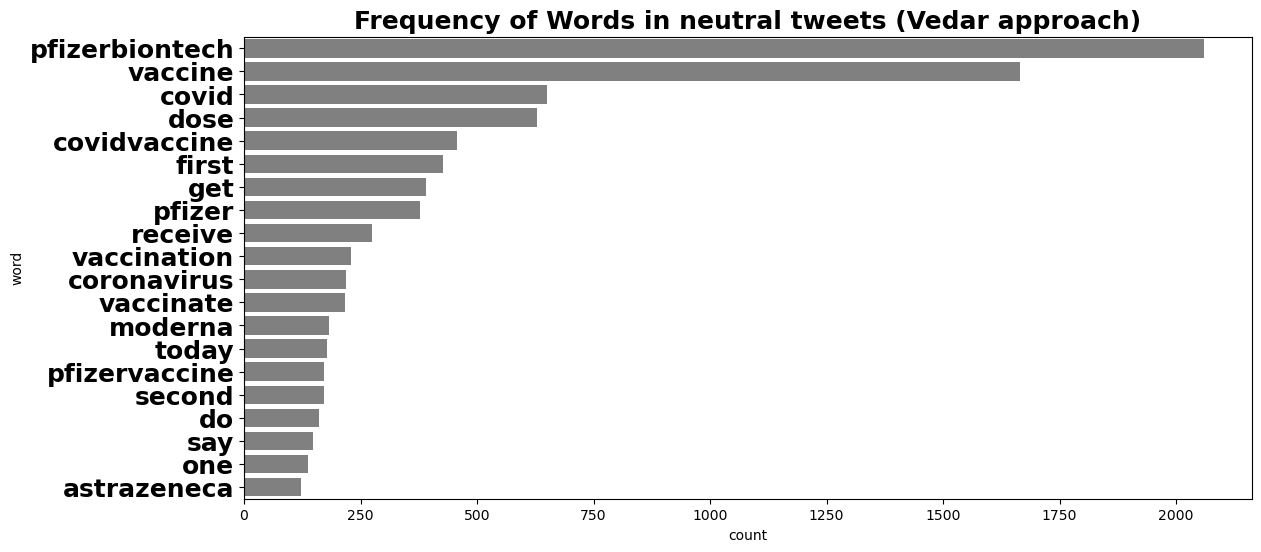

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using Seaborn
plt.figure(figsize=(13, 6))
sns.barplot(x='count', y='word', data=freq_dist.nlargest(20, 'count').sort_values('count', ascending=False), color='gray')
plt.title('Frequency of Words in neutral tweets (Vedar approach)' ,fontsize=18, weight='bold')

# Adjust the font size of the y-axis tick labels
plt.yticks(fontsize=18, weight='bold')

plt.show()


# Adjectives

In [101]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def clean_text_and_keep_adjectives(text):
    text = re.sub("[^a-zA-Z]"," ",text)
    text = ' '.join(text.split())
    text = text.lower()
    doc = nlp(text)
    adjectives = [token.text for token in doc if token.pos_ == 'ADJ' and token.text not in ['dose', 'covid']]
    return ' '.join(adjectives)


In [102]:
pos_tweets['clean_adj_text'] = pos_tweets['text'].apply(clean_text_and_keep_adjectives)

In [103]:
total_adjectives = ' '.join(pos_tweets['clean_adj_text'])
total_adjectives = total_adjectives.split()
freq_dist_adjectives = nltk.FreqDist(total_adjectives)
freq_dist_adjectives = pd.DataFrame({'word':list(freq_dist_adjectives.keys()),'count':list(freq_dist_adjectives.values())})

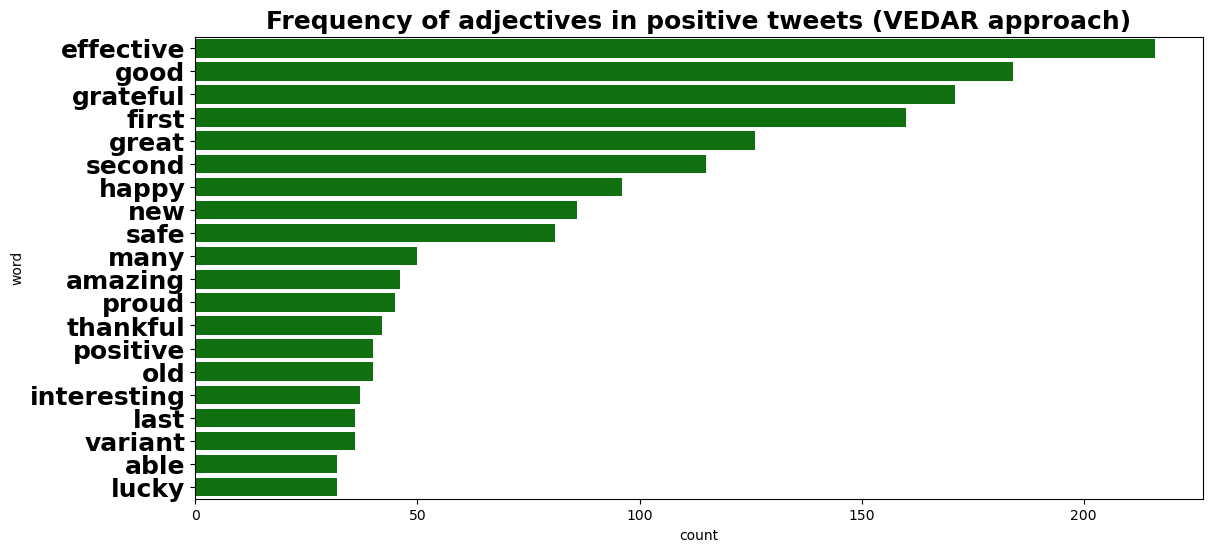

In [104]:
# Create a bar plot using Seaborn
plt.figure(figsize=(13, 6))
sns.barplot(x='count', y='word', data=freq_dist_adjectives.nlargest(20, 'count').sort_values('count', ascending=False), color='green')
plt.title('Frequency of adjectives in positive tweets (VEDAR approach)' ,fontsize=18, weight='bold')

# Adjust the font size of the y-axis tick labels
plt.yticks(fontsize=18, weight='bold')

plt.show()


In [105]:
neg_tweets['clean_adj_text'] = neg_tweets['text'].apply(clean_text_and_keep_adjectives)
total_adjectives = ' '.join(neg_tweets['clean_adj_text'])
total_adjectives = total_adjectives.split()
freq_dist_adjectives = nltk.FreqDist(total_adjectives)
freq_dist_adjectives = pd.DataFrame({'word':list(freq_dist_adjectives.keys()),'count':list(freq_dist_adjectives.values())})

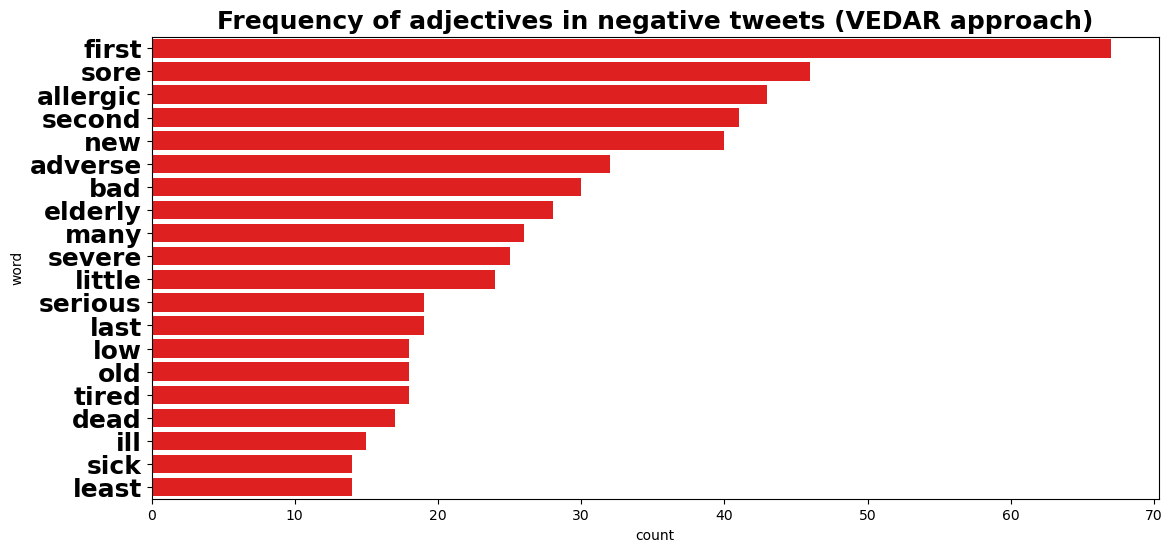

In [106]:
# Create a bar plot using Seaborn
plt.figure(figsize=(13, 6))
sns.barplot(x='count', y='word', data=freq_dist_adjectives.nlargest(20, 'count').sort_values('count', ascending=False), color='red')
plt.title('Frequency of adjectives in negative tweets (VEDAR approach)' ,fontsize=18, weight='bold')

# Adjust the font size of the y-axis tick labels
plt.yticks(fontsize=18, weight='bold')

plt.show()


In [107]:
neu_tweets['clean_adj_text'] = neu_tweets['text'].apply(clean_text_and_keep_adjectives)
total_adjectives = ' '.join(neu_tweets['clean_adj_text'])
total_adjectives = total_adjectives.split()
freq_dist_adjectives = nltk.FreqDist(total_adjectives)
freq_dist_adjectives = pd.DataFrame({'word':list(freq_dist_adjectives.keys()),'count':list(freq_dist_adjectives.values())})

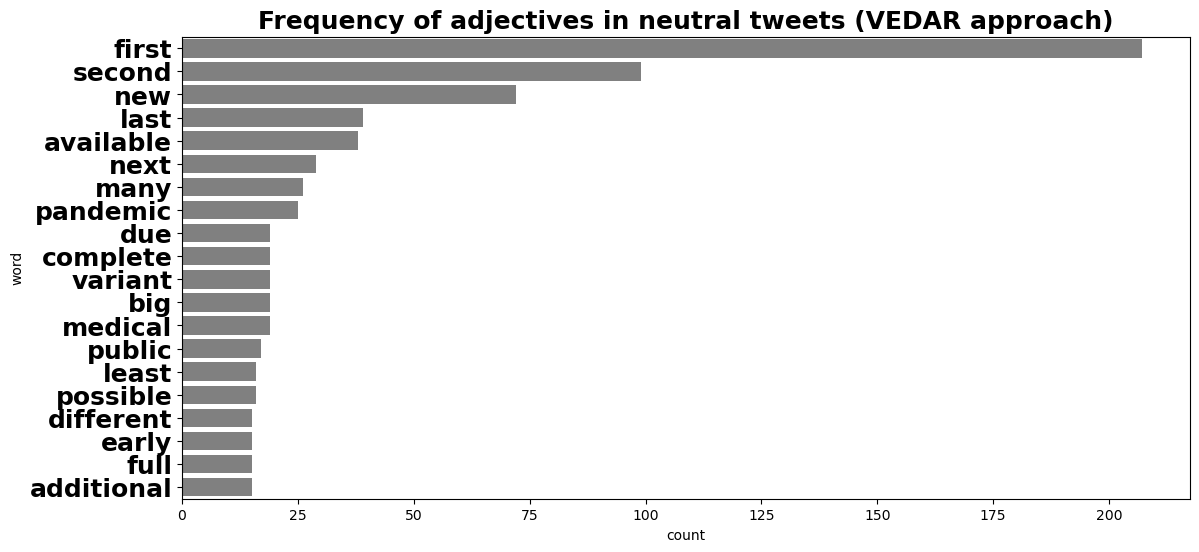

In [108]:
# Create a bar plot using Seaborn
plt.figure(figsize=(13, 6))
sns.barplot(x='count', y='word', data=freq_dist_adjectives.nlargest(20, 'count').sort_values('count', ascending=False), color='gray')
plt.title('Frequency of adjectives in neutral tweets (VEDAR approach)' ,fontsize=18, weight='bold')

# Adjust the font size of the y-axis tick labels
plt.yticks(fontsize=18, weight='bold')

plt.show()


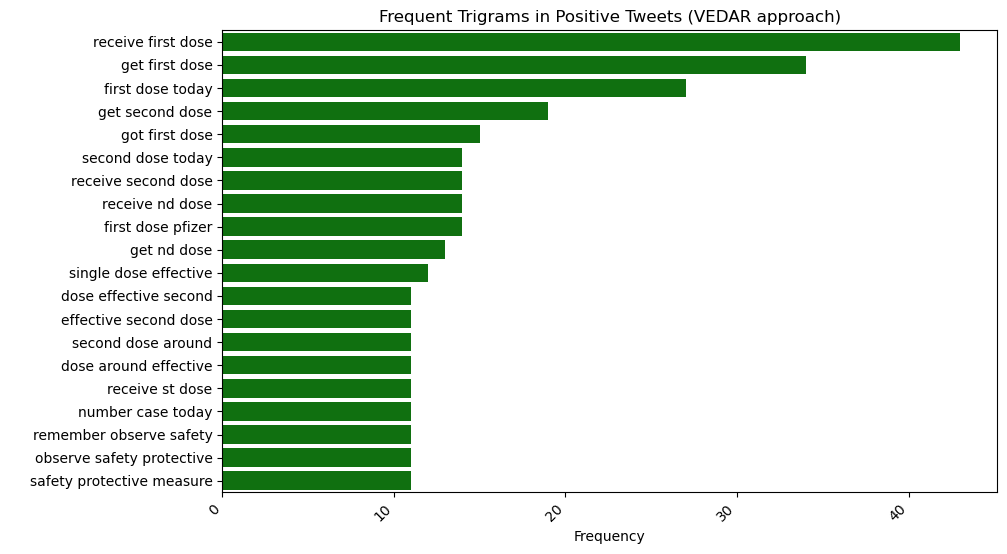

In [109]:
from nltk.util import ngrams
from collections import Counter

# Define the words to remove
remove_words = ["pfizerbiontech", "vaccine", "covid", "covidvaccine"]

# Function to remove specified words
def remove_words_from_text(text, words):
    words = set(words)
    return ' '.join([word for word in text.split() if word.lower() not in words])

# Remove the specified words from the clean_text column
pos_tweets['clean_text_no_specific_words'] = pos_tweets['clean_text'].apply(lambda x: remove_words_from_text(x, remove_words))

# Tokenize into bigrams
pos_tweets['bigrams_no_specific_words'] = pos_tweets['clean_text_no_specific_words'].apply(lambda x: [' '.join(gram) for gram in ngrams(x.split(), 3)])

# Count the occurrences of each bigram
all_bigrams = [bigram for sublist in pos_tweets['bigrams_no_specific_words'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)

# Get the 20 most frequent bigrams
top_bigrams = bigram_freq.most_common(20)

# Convert the list of tuples to a DataFrame
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most frequent bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, color= 'green')
plt.ylabel(" ")
plt.xlabel("Frequency")
plt.xticks(rotation=45, ha='right') 
plt.title("Frequent Trigrams in Positive Tweets (VEDAR approach)")
plt.show()


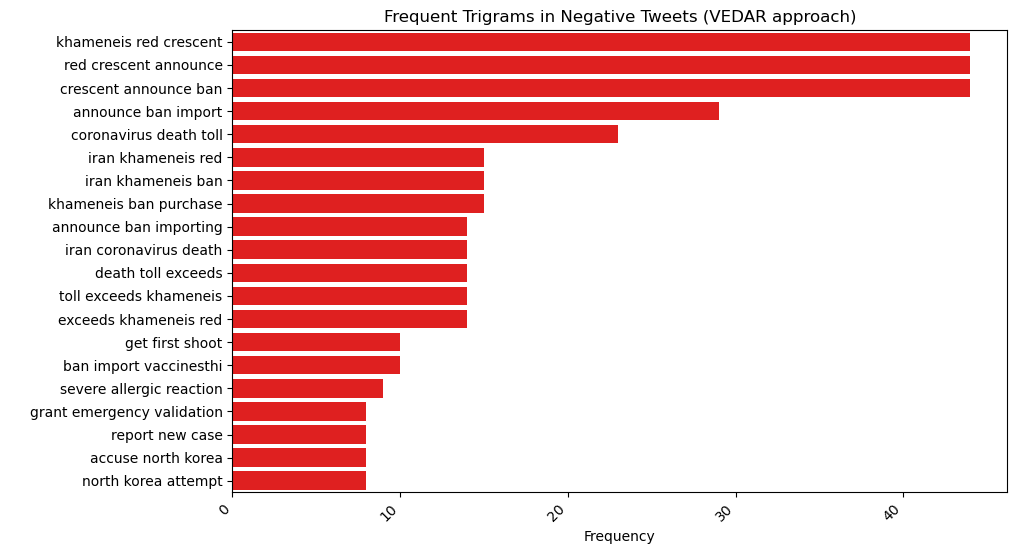

In [110]:
# Remove the specified words from the clean_text column
neg_tweets['clean_text_no_specific_words'] = neg_tweets['clean_text'].apply(lambda x: remove_words_from_text(x, remove_words))

# Tokenize into bigrams
neg_tweets['bigrams_no_specific_words'] = neg_tweets['clean_text_no_specific_words'].apply(lambda x: [' '.join(gram) for gram in ngrams(x.split(), 3)])

# Count the occurrences of each bigram
all_bigrams = [bigram for sublist in neg_tweets['bigrams_no_specific_words'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)

# Get the 20 most frequent bigrams
top_bigrams = bigram_freq.most_common(20)

# Convert the list of tuples to a DataFrame
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most frequent bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, color= 'red')
plt.ylabel(" ")
plt.xlabel("Frequency")
plt.xticks(rotation=45, ha='right') 
plt.title("Frequent Trigrams in Negative Tweets (VEDAR approach)")
plt.show()


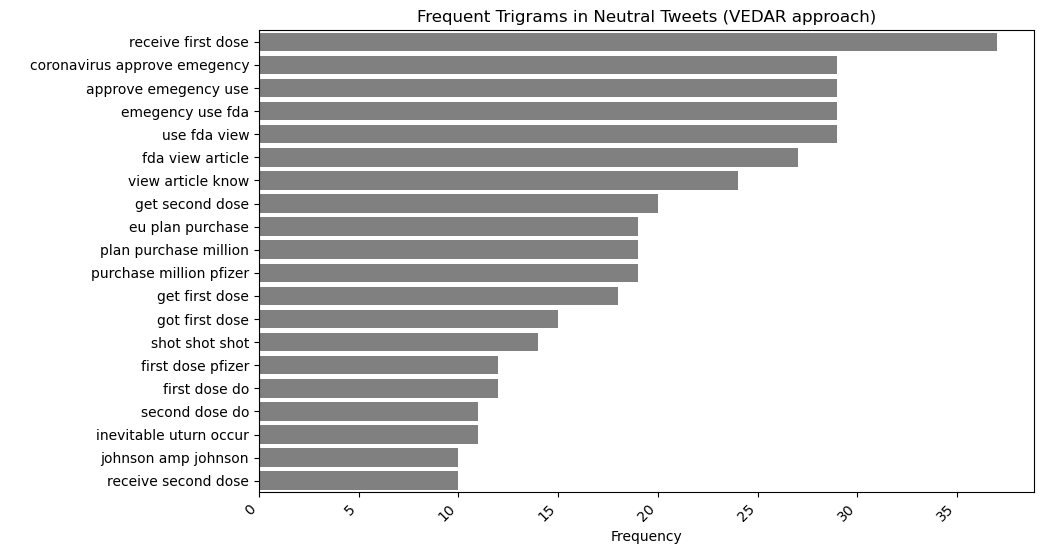

In [111]:
# Remove the specified words from the clean_text column
neu_tweets['clean_text_no_specific_words'] = neu_tweets['clean_text'].apply(lambda x: remove_words_from_text(x, remove_words))

# Tokenize into bigrams
neu_tweets['bigrams_no_specific_words'] = neu_tweets['clean_text_no_specific_words'].apply(lambda x: [' '.join(gram) for gram in ngrams(x.split(), 3)])

# Count the occurrences of each bigram
all_bigrams = [bigram for sublist in neu_tweets['bigrams_no_specific_words'] for bigram in sublist]
bigram_freq = Counter(all_bigrams)

# Get the 20 most frequent bigrams
top_bigrams = bigram_freq.most_common(20)

# Convert the list of tuples to a DataFrame
top_bigrams_df = pd.DataFrame(top_bigrams, columns=['Bigram', 'Frequency'])

# Plot the most frequent bigrams
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Bigram', data=top_bigrams_df, color= 'gray')
plt.ylabel(" ")
plt.xlabel("Frequency")
plt.xticks(rotation=45, ha='right') 
plt.title("Frequent Trigrams in Neutral Tweets (VEDAR approach)")
plt.show()


In [188]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer (max_features=3000, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
features = vectorizer.fit_transform(text_df['text'].values).toarray()

In [190]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, text_df['sentiment_vader'].values, test_size=0.25, random_state=42)

In [191]:
result_accuracies = []

In [194]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()
t0 = time.time()
lsvc.fit(X_train, y_train)
t1 = time.time()
lsvc_pred = lsvc.predict(X_test)
t2 = time.time()
time_to_train = t1-t0
time_to_predict = t2-t1     ## results
print("Time to train: %fs; Time for Prediction: %fs" % (time_to_train, time_to_predict))

Time to train: 0.135635s; Time for Prediction: 0.014822s


In [195]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test, lsvc_pred))
print()
lsvc_result = accuracy_score(y_test, lsvc_pred)
print(lsvc_result)
result_accuracies.append(lsvc_result)
print()
print(classification_report(y_test, lsvc_pred))

[[253  70  44]
 [ 22 793  18]
 [ 44  76 699]]

0.8642892521050025

              precision    recall  f1-score   support

    Negative       0.79      0.69      0.74       367
     Neutral       0.84      0.95      0.90       833
    Positive       0.92      0.85      0.88       819

    accuracy                           0.86      2019
   macro avg       0.85      0.83      0.84      2019
weighted avg       0.87      0.86      0.86      2019



In [285]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lsvc_pred)

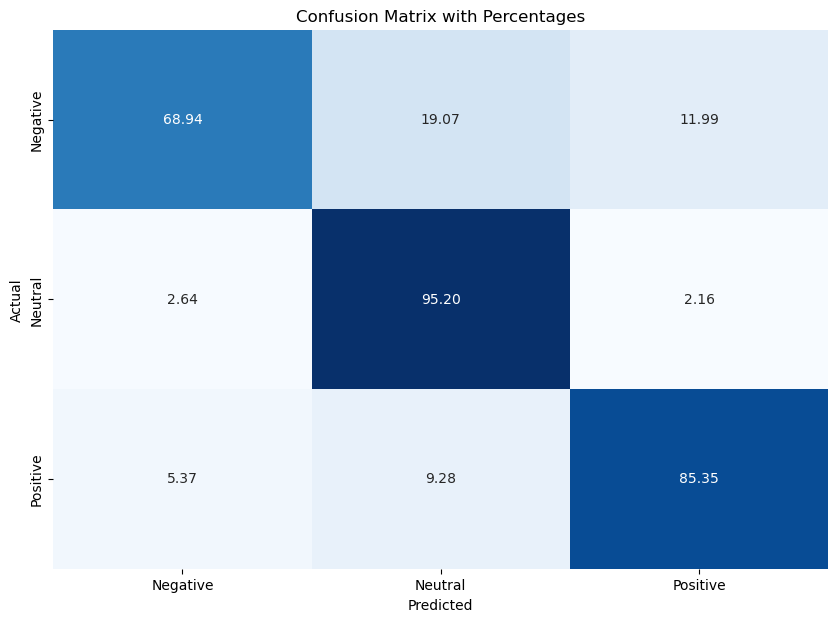

In [291]:
cm = confusion_matrix(y_test, lsvc_pred)
class_labels = ['Negative','Neutral', 'Positive']
# Calculate percentage confusion matrix
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Percentages')
plt.show()